In [1]:
"""
import packages
"""
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
import datetime as dt
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks

In [2]:
"""
import custom packages
"""
# from module_.info.testbed_info import d_files, g_files, c_files, p_files
from module_.info.testbed_info import activityfiles_new
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
# from module_.evaluation import evaluation_
# from module_.analysis import neighbor_events as ne
# from module_.helper.labeling import feature_label

# Testbed (Seminar, multi-resident, episodes)

In [3]:
"""
load raw files
"""
dir_="dataset/testbed/npy/seminar"
task_dict={i:[np.load("{}/{}".format(dir_, name)) for name in v] for i, v in enumerate(activityfiles_new.values())}
initial_dict={i:k[0] for i, k in enumerate(activityfiles_new.keys())}
label_dict={k[0]:k for k in activityfiles_new.keys()}
# task_dict={
#     0:  [np.load(dir_+file_name) for file_name in g_files.keys()],
#     1:  [np.load(dir_+file_name) for file_name in d_files.keys()],
#     2:  [np.load(dir_+file_name) for file_name in c_files.keys()],
#     3:  [np.load(dir_+file_name) for file_name in p_files.keys()]
# }
# name_dict={
#     0: 'G', 1: 'D', 2: 'C', 3: 'P'
# }

episodes, trs, tags = create_episodes(task_dict, initial_dict)
episodes=[time_correction(eps, trs[i]) for i, eps in enumerate(episodes)]

2 C0T2
[['Seat4A' 'true' '1496679716.']
 ['Seat4A' 'false' '1496679875.']
 ['Seat3A' 'false' '1496680221.']
 ['Seat4A' 'true' '1496680534.']
 ['Seat4A' 'false' '1496680579.']
 ['Seat6A' 'false' '1496680603.']
 ['Seat6A' 'true' '1496680613.']
 ['Seat6A' 'false' '1496680623.']
 ['Seat6A' 'true' '1496680633.']
 ['Seat4A' 'true' '1496680634.']
 ['Seat4A' 'false' '1496680724.']
 ['Seat6A' 'false' '1496680748.']
 ['Seat4A' 'true' '1496680799.']
 ['Seat6A' 'true' '1496680822.']
 ['Seat5B' 'false' '1496680825.']
 ['Seat6A' 'false' '1496680863.']
 ['Seat6A' 'true' '1496680868.']
 ['Seat6A' 'false' '1496680947.']
 ['Seat6A' 'true' '1496680973.']
 ['Seat6A' 'false' '1496681022.']
 ['Seat6A' 'true' '1496681028.']
 ['Seat4A' 'false' '1496681278.']
 ['Seat4A' 'true' '1496681308.']
 ['Seat4A' 'false' '1496681318.']
 ['Seat4A' 'true' '1496681348.']
 ['Seat4A' 'false' '1496681373.']
 ['Seat4A' 'true' '1496681448.']
 ['Seat4A' 'false' '1496681453.']
 ['Seat4A' 'true' '1496681613.']
 ['Seat4A' 'false' '1

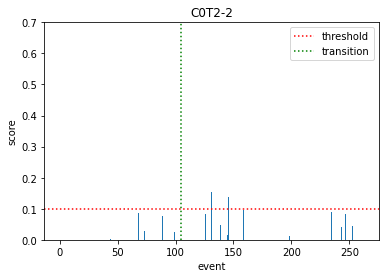

In [11]:
"""make combinations
    1. pick one group type
    2. pick an activity stream from the group
    3. pick another group type w/o type 1.
    4. pick an activity stream from the group
"""
data_name='testbed'
metric='SEP'

for i, eps in enumerate(episodes):
    if i<2:
        continue
    pairname="{}-{}".format(label_dict[tags[i][0]], label_dict[tags[i][2]])
    print(i, tags[i])
    sensor_list=sorted(set(eps[:,0]))
    features=feature_extraction(eps, data_name, sensor_list)
    scores=change_point_detection(features, i, pairname, data_name=data_name, metric=metric, save=True)

    print(eps[120:150])
    # scores=np.array(scores)

    # scores=[scores[max(0, si-1)]+scores[max(0, si-2)] for si in range(len(scores))]
    # scores[scores<0]=0

    # peak, _ =find_peaks(scores)
    # positive=[i for i in peak if scores[i]>0.1]
    # positive=[i for i in range(len(scores)) if scores[i]>0.45]
    
###
    plt.title("{}-{}".format(tags[i], i))
    plt.ylabel('score')
    plt.xlabel('event')
    plt.ylim(0,0.7)
    plt.bar(range(len(eps)), scores)
    # plt.plot(positive, np.array(scores)[positive], 'bx', label='peak')
    plt.axhline(y=0.1, linestyle=':', color='r', label='threshold')
    plt.axvline(x=trs[i], linestyle=':', color='g', label='transition')
    plt.legend()
    plt.savefig("./outputs/{}/{}/{}/{}/graph.png".format(data_name, metric, pairname, i))
    # plt.clf()
    break
###

# Evaluation

In [5]:
"""
    hh101 Evaluation
    - load scores
"""
total_counts=np.zeros(4)
denom = numer = 0
for activity_folder in glob.glob("./outputs/{}/{}/*".format(data_name, metric)):
    if "ETC" in activity_folder:
        continue
    # one type of pairs
    activity_pair=activity_folder.split("/")[-1]
    print(activity_pair)
    pair_counts=np.zeros(4) # TP, FP, TN, FN

    for episode_folder in glob.glob("{}/*".format(activity_folder)):
        denom+=1
        eps_order=int(episode_folder.split("/")[-1])
        eps, point=episodes[eps_order], trs[eps_order]
        scores=np.load("{}/scores.npy".format(episode_folder))

        peaks, _ = find_peaks(scores)
        positives=[i for i in peaks if scores[i]>0.1]
        numer+=len(positives)
        # positives=[i for i in range(len(scores)) if scores[i]>0.3]
        ttimestamp=float(eps[point][2])

        for i in range(len(scores)):
            if i in positives:
                if i==point:
                    pair_counts[0]+=1
                else:
                    timestamp_b=float(eps[i-1][2])
                    timestamp_a=float(eps[i][2])
                    if abs(ttimestamp-timestamp_b)<60 or abs(ttimestamp-timestamp_a)<60:
                        pair_counts[0]+=1
                    else:
                        pair_counts[1]+=1
            else:
                if i==point:
                    pair_counts[3]+=1
                else:
                    pair_counts[2]+=1
    TPR_=pair_counts[0]/(pair_counts[0]+pair_counts[3])
    FPR_=pair_counts[1]/(pair_counts[1]+pair_counts[2])
    print("Avg. TPR and FPR: ({}, {})".format(TPR_, FPR_))

    total_counts+=pair_counts

TPR=total_counts[0]/(total_counts[0]+total_counts[3])
FPR=total_counts[1]/(total_counts[1]+total_counts[2])
print("Total Avg. TPR and FPR: ({}, {})".format(TPR, FPR))

print(numer/denom)

Seminar-TechnicalDiscussion
Avg. TPR and FPR: (0.18181818181818182, 0.04291536801726205)
Seminar-Chatting
Avg. TPR and FPR: (0.25, 0.03748326639892905)
TechnicalDiscussion-GroupStudy
Avg. TPR and FPR: (0.0, 0.03141640042598509)
Chatting-GroupStudy
Avg. TPR and FPR: (0.0, 0.024864024864024864)
GroupStudy-TechnicalDiscussion
Avg. TPR and FPR: (0.3333333333333333, 0.03810285105249134)
Chatting-TechnicalDiscussion
Avg. TPR and FPR: (0.1111111111111111, 0.025910931174089068)
GroupStudy-Seminar
Avg. TPR and FPR: (0.36363636363636365, 0.03914473684210526)
Chatting-Seminar
Avg. TPR and FPR: (0.18181818181818182, 0.0351288056206089)
TechnicalDiscussion-Seminar
Avg. TPR and FPR: (0.1, 0.03811121764141898)
GroupStudy-Chatting
Avg. TPR and FPR: (0.25, 0.027226760015558148)
Seminar-GroupStudy
Avg. TPR and FPR: (0.2, 0.042420256494574156)
TechnicalDiscussion-Chatting
Avg. TPR and FPR: (0.25, 0.030253916801728797)
Total Avg. TPR and FPR: (0.1953125, 0.03474865305718946)
13.25


# Positive Analysis

In [6]:
data_name='testbed'
metric='SEP'
for activity_folder in glob.glob("./outputs/{}/{}/NOMOTION/*".format(data_name, metric)):
    activity_pair=activity_folder.split("/")[-1]
    print(activity_pair)

    for episode_folder in glob.glob("{}/*".format(activity_folder)):
        eps_order=int(episode_folder.split("/")[-1])
        eps, point=episodes[eps_order], trs[eps_order]
        sensor_list=sorted(set(eps[:,0]))
        features=feature_extraction(eps, data_name, sensor_list)
        features=np.array(features)
        scores=np.load("{}/scores.npy".format(episode_folder))
        lambdas=np.load("{}/lambdas.npy".format(episode_folder))
        sigmas=np.load("{}/sigmas.npy".format(episode_folder))
        thetas=np.load("{}/thetas.npy".format(episode_folder))

        peaks, _ = find_peaks(scores)
        positives=[p for p in peaks if scores[p]>0.1]
        
        ttimestamp=float(eps[point][2])
        true_positives=[p for p in positives if abs(ttimestamp-float(eps[p][2]))<=30]
        false_positives=[p for p in positives if p not in true_positives]
        
        # creating window of the latest event
        events_true_positives=[]
        for p in true_positives:
            bucket=[]
            idx=p-30
            while idx!=p:
                bucket.append(eps[max(0, idx),:])
                idx+=1
            bucket.append(eps[p,:])
            bucket.append(eps[min(len(eps)-1,p+1)])
            bucket.append(eps[min(len(eps)-1,p+2)])
            events_true_positives.append(np.array(bucket))
        
        events_false_positives=[]
        for p in false_positives:
            bucket=[]
            idx=p-30
            while idx!=p:
                bucket.append(eps[max(0, idx),:])
                idx+=1
            bucket.append(eps[p,:])
            bucket.append(eps[min(len(eps)-1,p+1)])
            bucket.append(eps[min(len(eps)-1,p+2)])
            events_false_positives.append(np.array(bucket))

        features_true_positives=[np.array(features)[[max(0,p-1),p,min(len(features)-1,p+1),min(len(features)-1,p+2)]] for p in true_positives]
        features_false_positives=[np.array(features)[[max(0,p-1),p,min(len(features)-1,p+1),min(len(features)-1,p+2)]] for p in false_positives]

        parameters_true_positives=[[lambdas[p], sigmas[p][0], sigmas[p][1]] for p in true_positives]
        parameters_false_positives=[[lambdas[p], sigmas[p][0], sigmas[p][1]] for p in false_positives]

        scores_true_positives=[scores[p] for p in true_positives]
        scores_false_positives=[scores[p] for p in false_positives]

        positive_folder="{}/positive".format(episode_folder)
        true_folder="{}/true".format(positive_folder)
        false_folder="{}/false".format(positive_folder)

        if not os.path.exists(positive_folder):
            os.mkdir(positive_folder)
        if not os.path.exists(true_folder):
            os.mkdir(true_folder)
        if not os.path.exists(false_folder):
            os.mkdir(false_folder)

        np.save("{}/events.npy".format(true_folder), events_true_positives)
        np.save("{}/features.npy".format(true_folder), features_true_positives)
        np.save("{}/parameters.npy".format(true_folder), parameters_true_positives)
        np.save("{}/scores.npy".format(true_folder), scores_true_positives)

        np.save("{}/events.npy".format(false_folder), events_false_positives)
        np.save("{}/features.npy".format(false_folder), features_false_positives)
        np.save("{}/parameters.npy".format(false_folder), parameters_false_positives)
        np.save("{}/scores.npy".format(false_folder), scores_false_positives)
        

# False Positive Analysis

In [7]:
data_name='testbed'
metric='SEP'

for afolder in glob.glob("./outputs/testbed/SEP/NOMOTION/*"):
    print(afolder)
    for efolder in glob.glob("{}/*".format(afolder)):
        fpevents=np.load("{}/positive/false/events.npy".format(efolder))
        fpfeatures=np.load("{}/positive/false/features.npy".format(efolder))
        fpparameters=np.load("{}/positive/false/parameters.npy".format(efolder))
        fpscores=np.load("{}/positive/false/scores.npy".format(efolder))

        order=9
        # print(dt.datetime.fromtimestamp(float(fpevents[order][-3,2])))
        # print(fpevents.shape, fpfeatures.shape, fpparameters.shape)
        
        print(fpscores[order], fpparameters[order])
        # print(np.round(fpfeatures[order],2))
        # print(fpevents[order])

        print(np.array([item for item in fpevents[order] if item[1]=='true']))


        break
    break

# True Positive Analysis

In [8]:
data_name='testbed'
metric='SEP'

for afolder in glob.glob("./outputs/testbed/SEP/NOMOTION/*"):
    pairname=afolder.split("/")[-1]
    print(afolder)
    for efolder in glob.glob("{}/*".format(afolder)):
        epsnumber=efolder.split("/")[-1]
        print(efolder)
        tpevents=np.load("{}/positive/true/events.npy".format(efolder))
        tpfeatures=np.load("{}/positive/true/features.npy".format(efolder))
        tpparameters=np.load("{}/positive/true/parameters.npy".format(efolder))
        tpscores=np.load("{}/positive/true/scores.npy".format(efolder))
        
        if tpevents.shape[0]==0:
            continue
        
        for order in range(tpevents.shape[0]):
            # true_events=np.array([item for item in tpevents[order] if item[1]=='true'])

            target=tpevents[order]

            min_timestamp=min([float(event[2]) for event in target])
            sensor_timestamp={item:[] for item in set(target[:,0])}
            for event in target:
                sensor_timestamp[event[0]].append(float(event[2])-min_timestamp)

            plt.title("True-Positive-{}".format(order))
            plt.xlabel("timestamp")
            yintv=0.01
            for k, v in sensor_timestamp.items():
                plt.plot(v, [yintv for _ in range(len(v))], 'o', label=k)
                for time_ in v:
                    plt.axvline(x=time_, linestyle=":")
                yintv+=0.01
            plt.legend()
            plt.savefig("./analysis/{}/{}/positive/true/NOMOTION/{}_{}_{}.png".format(data_name, metric, pairname, epsnumber, order))
            plt.clf()

# False Positive Analysis

In [9]:
data_name='testbed'
metric='SEP'

for afolder in glob.glob("./outputs/testbed/SEP/NOMOTION/*"):
    pairname=afolder.split("/")[-1]
    print(afolder)
    for efolder in glob.glob("{}/*".format(afolder)):
        epsnumber=efolder.split("/")[-1]
        print(efolder)
        tpevents=np.load("{}/positive/false/events.npy".format(efolder))
        tpfeatures=np.load("{}/positive/false/features.npy".format(efolder))
        tpparameters=np.load("{}/positive/false/parameters.npy".format(efolder))
        tpscores=np.load("{}/positive/false/scores.npy".format(efolder))
        
        if tpevents.shape[0]==0:
            continue
        
        for order in range(tpevents.shape[0]):
            # true_events=np.array([item for item in tpevents[order] if item[1]=='true'])

            target=tpevents[order]

            min_timestamp=min([float(event[2]) for event in target])
            sensor_timestamp={item:[] for item in set(target[:,0])}
            for event in target:
                sensor_timestamp[event[0]].append(float(event[2])-min_timestamp)

            plt.title("False-Positive-{}".format(order))
            plt.xlabel("timestamp")
            yintv=0.01
            for k, v in sensor_timestamp.items():
                plt.plot(v, [yintv for _ in range(len(v))], 'o', label=k)
                for time_ in v:
                    plt.axvline(x=time_, linestyle=":")
                yintv+=0.01
            plt.legend()
            plt.savefig("./analysis/{}/{}/positive/false/NOMOTION/{}_{}_{}.png".format(data_name, metric, pairname, epsnumber, order))
            plt.clf()
        break